In [1]:
%matplotlib inline
import os, sys
#import modules
from utils import *
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.models import Model, load_model
from keras import backend as K

import os, json

from keras.layers import Input
from keras.optimizers import SGD, RMSprop, Adam
from enum import Enum
from keras.layers.core import Dense
from utils import save_array, load_array


DATA_HOME_DIR = '/srv/'
# DATA_HOME_DIR = '/home/ubuntu/blocks_classifier/data/dogscats' # on ec2

reload(K)
K.image_dim_ordering()

Using TensorFlow backend.
Using TensorFlow backend.


'tf'

In [2]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR  #'/sample/'

/srv


In [3]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
                                   class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)
#     return gen.flow(dirname, target_size=target_size,
#             class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [4]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_array(fpath, filenames, titles=None):
    plots([image.load_img(fpath+f) for f in filenames], titles=titles)
    

    
#Number of images to view for each visualization task
n_view = 4

## Fully convolutional neural net

In [5]:
class BaseModels(Enum):
    inception = "InceptionV3"
    vgg = "VGG16"
output_classes = ["one", "ten"]

In [6]:
base_model = VGG16(include_top=True, weights='imagenet') ## functional API

In [12]:
base_model.summary()
base_model.layers[-5].output_shape

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

(None, 7, 7, 512)

In [32]:
## replaces last dense layer with another dense layer of size the number of classes
x = base_model.layers[-2].output ## output is prior to last output
predictions = Dense(len(output_classes), activation='softmax', name = "predictions")(x)
ft_model = Model(input=base_model.input, output=predictions)
optimizer = Adam(lr=0.001) #SGD(lr=0.001) Adam seems to work much better than SGD?

## Freezes all but last layers
for layer in ft_model.layers:
    layer.trainable = False

## Make the last 2 dense layers trainable
for layer in ft_model.layers[-1:]:
    layer.trainable = True

ft_model.compile(optimizer=optimizer,
                loss='categorical_crossentropy', metrics=['accuracy'])



In [8]:
ft_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
block1_conv1 (Convolution2D)     (None, 224, 224, 64)  1792        input_1[0][0]                    
____________________________________________________________________________________________________
block1_conv2 (Convolution2D)     (None, 224, 224, 64)  36928       block1_conv1[0][0]               
____________________________________________________________________________________________________
block1_pool (MaxPooling2D)       (None, 112, 112, 64)  0           block1_conv2[0][0]               
___________________________________________________________________________________________

## Getting training data

In [9]:
# %matplotlib inline
# path = "/srv/"

# import utils; reload(utils)
# from utils import plots
# from keras.preprocessing import image
# import numpy as np


ImportError: No module named utils

### Get batch data

In [10]:
batch_size=8

In [29]:
def get_batches(path, shuffle=True, batch_size=8, class_mode='categorical'):
        ## option 1 - no image augmentation
        data_augmentation = True
        if data_augmentation:
            gen=image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, channel_shift_range=10., horizontal_flip=True, vertical_flip=True, dim_ordering='tf')
        else:
            gen=image.ImageDataGenerator(dim_ordering='tf')


        return gen.flow_from_directory(path, target_size=(224,224),
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [30]:
batches = get_batches(path+'training', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2)

Found 633 images belonging to 2 classes.
Found 88 images belonging to 2 classes.


### Train

In [33]:
ft_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=3,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/3
633/633 [==============================] - 355s - loss: 0.1829 - acc: 0.9415 - val_loss: 0.0630 - val_acc: 0.9773

In [24]:
ft_model.save(path+"ft_model.h5")

# Check the results

In [34]:
def model_predict(image_path, batch_size = batch_size):
    p_batches = get_batches(image_path, batch_size=batch_size, shuffle=False, class_mode=None)
    pred = ft_model.predict_generator(p_batches,p_batches.nb_sample)
    return p_batches, pred

In [35]:
valid_path = path + 'valid/'
val_batches, val_predict = model_predict(valid_path,batch_size)

Found 88 images belonging to 2 classes.


In [36]:
val_filenames = val_batches.filenames
val_classes = val_batches.classes

### Couple of valid ones

correct ones 39


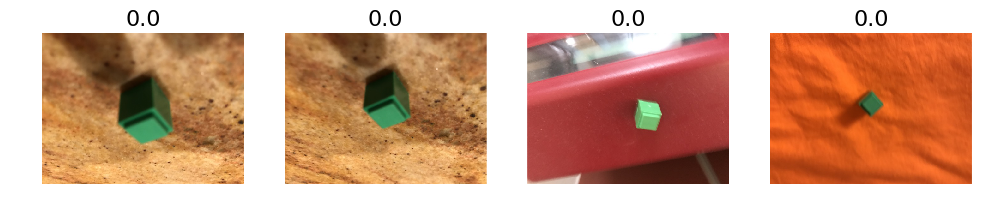

In [37]:
our_prediction = 1-val_predict[:,0]
our_class_prediction = np.round(our_prediction)
correct_cats = np.where((val_classes == 0) & (our_class_prediction == 0))[0]
print "correct ones %d" % len(correct_cats)
idx = permutation(correct_cats)[:n_view]
plots_array(valid_path, np.array(val_filenames)[idx], our_class_prediction[idx])

###  Invalid ones and tens

In [38]:
incorrect = np.where(val_classes!=our_class_prediction)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_array(valid_path, np.array(val_filenames)[idx], our_class_prediction[idx])

Found 0 incorrect labels


IndexError: list index out of range

### Couple of valid tens

correct tens 49
88


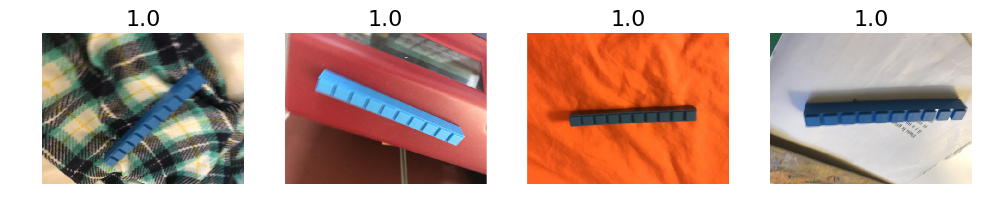

In [39]:
correct_dogs = np.where((val_classes == 1) & (our_class_prediction == 1))[0]
print "correct tens %d" % len(correct_dogs)
idx = permutation(correct_dogs)[:n_view]
print len(val_filenames)
plots_array(valid_path, np.array(val_filenames)[idx], our_class_prediction[idx])

###  Invalid ones and tens

In [ ]:
incorrect = np.where(val_classes!=our_class_prediction)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_array(valid_path, np.array(val_filenames)[idx], our_class_prediction[idx])

### Most wrong ones

In [13]:
predictions = ft_model.predict(imgs)
idxs = np.argmax(predictions, axis=1)
# get the values of the highest probability for each image
preds = [predictions[i, idxs[i]] for i in range(len(idxs))]
pred_classes = [output_classes[idx] for idx in idxs]


In [14]:
print preds, pred_classes

[0.96552646, 0.99862325, 0.98411167, 0.90069962, 0.99750012, 0.99850571, 0.9981249, 0.99993598] ['ten', 'ten', 'one', 'ten', 'one', 'ten', 'ten', 'ten']


## CoreML Conversion

In [40]:
import coremltools

In [16]:
from keras.models import load_model
ft_model = load_model(path+"ft_model.h5")



In [41]:
coreml_model = coremltools.converters.keras.convert(ft_model, input_names = 'image', image_input_names = 'image', class_labels = output_classes, is_bgr=True, red_bias=-123.68, green_bias=-116.78, blue_bias=-103.94)

0 : input_2, <keras.engine.topology.InputLayer object at 0x7f6e2143fd50>
1 : block1_conv1, <keras.layers.convolutional.Convolution2D object at 0x7f6e21628450>
2 : block1_conv1__activation__, <keras.layers.core.Activation object at 0x7f6e2163d290>
3 : block1_conv2, <keras.layers.convolutional.Convolution2D object at 0x7f6e2143f6d0>
4 : block1_conv2__activation__, <keras.layers.core.Activation object at 0x7f6e2163dd50>
5 : block1_pool, <keras.layers.pooling.MaxPooling2D object at 0x7f6e21478990>
6 : block2_conv1, <keras.layers.convolutional.Convolution2D object at 0x7f6e21478c50>
7 : block2_conv1__activation__, <keras.layers.core.Activation object at 0x7f6e2163d810>
8 : block2_conv2, <keras.layers.convolutional.Convolution2D object at 0x7f6e21599ad0>
9 : block2_conv2__activation__, <keras.layers.core.Activation object at 0x7f6e2163ded0>
10 : block2_pool, <keras.layers.pooling.MaxPooling2D object at 0x7f6e2153c790>
11 : block3_conv1, <keras.layers.convolutional.Convolution2D object at 0x7

In [42]:
coreml_model.short_description = 'Categorize within 1 or 10 math-u-see blocks - Adam + image augmentation'

In [43]:
coreml_model.save(path+"vgg_image_adam_image_aug.mlmodel")